### Resources Used

* Dataset
 - https://docs.rapids.ai/datasets/mortgage-data
 - https://capmrkt.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html
* RAPIDS + Dask Documentation
 - https://docs.rapids.ai/api/cudf/stable/10min.html
 - https://docs.dask.org/en/latest/dataframe-best-practices.html
 - https://docs.dask.org/en/latest/setup/single-distributed.html#localcluster
 - https://distributed.dask.org/en/latest/memory.html
 - https://dask-cuda.readthedocs.io/en/latest/specializations.html
* Other examples with this dataset
 - https://www.dataquest.io/blog/data-science-portfolio-machine-learning/
 - https://github.com/dhananjaymehta/FannieMae_LoanForeclosure
 - https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/
 - https://riskspan.com/hands-on-machine-learning-predicting-loan-delinquency/
 
 
 






## Create conda enviornment with the following libraries
```
conda create -n rapids-0.17 -c rapidsai -c nvidia -c conda-forge -c defaults rapids-blazing=0.17 python=3.7 cudatoolkit=11.0 matplotlib=3.3.3 gcsfs=0.7.1
```

Once you create the conda environment open a Jupyter kernel associated to this conda environment

## Check Environment

In [1]:
%%bash
nvidia-smi
nvcc --version

Thu Jan 14 03:17:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    54W / 400W |      0MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [ ]:
import numpy as np; print('numpy Version:', np.__version__)
import pandas as pd; print('pandas Version:', pd.__version__)
import xgboost as xgb; print('XGBoost Version:', xgb.__version__)
import cudf; print('cudf Version:', cudf.__version__)
import cuml; print('cudf Version:', cuml.__version__)
import gcsfs; print('gcsfs Version:', gcsfs.__version__)
import time
import dask_cudf; print('dask_cudf Version:', gcsfs.__version__)
import dask; print('dask Version:', gcsfs.__version__)
import dask.dataframe as dask_df
import glob;
import matplotlib; print('matplotlib Version:', matplotlib.__version__)
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress, wait

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set up Dask Cluster

In [ ]:
# from dask.distributed import Client
# client = Client()
# client

In [4]:
import blazingsql
import dask_cudf
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
# bc = blazingsql.BlazingContext(dask_client=client, network_interface='lo')
client

Client Scheduler: tcp://127.0.0.1:41177 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 179.38 GB


In [ ]:
# client.restart()
# client

## Define Data Schema & Data Types

In [5]:
col_acq_names = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']
col_per_names = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator']

col_acq = ['LoanID','OrDate','OrUnpaidPrinc','Channel','SellerName','PropertyType','NumUnits','PropertyState']
col_per = ['LoanID','MonthRep', 'CAUPB','CLDS','ForeclosureDate']

parse_dates_acq =['OrDate','FirstPayment']
parse_dates_per =['MonthRep','MaturityDate','ZeroBalDate','LastInstallDate','ForeclosureDate','DispositionDate']

# dtype_acq={ "LoanID":"str","Channel":"str","SellerName":"str","OrInterestRate":"str","OrUnpaidPrinc":"str","OrLoanTerm":"str","OrDate":"str",
#    "FirstPayment":"str","OrLTV":"str","OrCLTV":"str",  "NumBorrow":"str", "DTIRat":"str", "CreditScore":"str", "FTHomeBuyer":"str",
#    "LoanPurpose":"str", "PropertyType":"str", "NumUnits":"str", "OccStatus":"str",  "PropertyState":"str",  "Zip":"str", "MortInsPerc":"str",
#    "ProductType":"str", "CoCreditScore":"str", "MortInsType":"str", "RelMortInd":"str"}

dtype_acq={ "LoanID":"int","Channel":"str","SellerName":"str","OrInterestRate":"float","OrUnpaidPrinc":"float","OrLoanTerm":"float","OrDate":"str",
   "FirstPayment":"str","OrLTV":"float","OrCLTV":"float",  "NumBorrow":"float", "DTIRat":"float", "CreditScore":"float", "FTHomeBuyer":"str",
   "LoanPurpose":"str", "PropertyType":"str", "NumUnits":"float", "OccStatus":"str",  "PropertyState":"str",  "Zip":"int", "MortInsPerc":"float",
   "ProductType":"str", "CoCreditScore":"float", "MortInsType":"float", "RelMortInd":"str"}

# dtype_per={"LoanID":"str","MonthRep":"str","Servicer":"str", "CurrInterestRate":"str", "CAUPB":"str", "LoanAge":"str","MonthsToMaturity":"str",
#    "AdMonthsToMaturity":"str", "MaturityDate":"str", "MSA":"str", "CLDS":"str", "ModFlag":"str", "ZeroBalCode":"str", "ZeroBalDate":"str",
#     "LastInstallDate":"str",  "ForeclosureDate":"str", "DispositionDate":"str", "PPRC":"str", "AssetRecCost":"str", "MHRC":"str", "ATFHP":"str",
#     "NetSaleProceeds":"str", "CreditEnhProceeds":"str","RPMWP":"str","OFP":"str","NIBUPB":"str", "PFUPB":"str", "RMWPF":"str",
#    "FPWA":"str", "ServicingIndicator":"str"
# }

dtype_per={"LoanID":"int","MonthRep":"str","Servicer":"str", "CurrInterestRate":"float", "CAUPB":"float", "LoanAge":"float","MonthsToMaturity":"float",
   "AdMonthsToMaturity":"float", "MaturityDate":"str", "MSA":"float", "CLDS":"float", "ModFlag":"str", "ZeroBalCode":"float", "ZeroBalDate":"str",
    "LastInstallDate":"str",  "ForeclosureDate":"str", "DispositionDate":"str", "PPRC":"float", "AssetRecCost":"float", "MHRC":"float", "ATFHP":"float",
    "NetSaleProceeds":"float", "CreditEnhProceeds":"float","RPMWP":"float","OFP":"float","NIBUPB":"float", "PFUPB":"float", "RMWPF":"float",
   "FPWA":"str", "ServicingIndicator":"str"
}

## Data Ingestion

In [6]:
# csv_acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/Acquisition_20*'
# csv_perf_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/Performance_20*'

parq_acq_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/acq/parquet68'
parq_per_fnames='gs://mchrestkha-github-ml-examples/fannie_mae_loans/perf/parquet823'

In [ ]:
# %time df_acq = dask_cudf.read_csv(csv_acq_fnames, sep='|', names=col_acq_names, dtype=dtype_acq, parse_dates=parse_dates_acq)
# %time df_pe = dask_cudf.read_csv(csv_perf_fnames, sep='|', names=col_per_names, dtype=dtype_per, parse_dates=parse_dates_per)

%time df_acq = dask_cudf.read_parquet(parq_acq_fnames)
%time df_per = dask_cudf.read_parquet(parq_per_fnames, columns=col_per)

In [ ]:
# %time print("Required Memory for df_acq:",df_acq.memory_usage().sum().compute()/(1024**3), 'GB')
# %time print("Required Memory for df_per:",df_per.memory_usage().sum().compute()/(1024**3), 'GB')

In [13]:
df_acq.head()
df_per.head()

In [ ]:
df_per_shape=df_per.shape[0].persist()
progress(df_per_shape)

In [12]:
df_per_shape.compute()
df_acq.shape[0].compute()

1890353680

37015214

## Data Profiling & Data Quality Check against Summary Statistics 
- Data Dictionary: https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf
- Sumary Statistics: https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Stat_Summary_Primary.pdf
- Sample Data: https://docs.google.com/spreadsheets/d/1nCtusAE2naZlWHFKGRsQTxxusjfZYiBLdd5SF5AEGMA/edit

In [ ]:
%time df_acq_describe=df_acq.describe().compute()
%time df_per_describe=df_per.describe().compute()
df_acq_describe
df_per_describe

In [ ]:
df_acq['OrYr']=df_acq['OrDate'].str[-4:]
df_acq['OrUnpaidPrinc $M']=df_acq['OrUnpaidPrinc']/1000000

In [ ]:
# df_acq_describe=df_acq.describe().compute()
# df_acq_nulls=df_acq.isna().sum().compute()
df_acq_describe
df_acq_nulls;

In [ ]:
%time df_acq_summary = df_acq.groupby('OrYr',as_index=False).agg({'LoanID': 'count','OrUnpaidPrinc $M': 'sum'}).compute()
df_acq_summary.rename(columns = {'LoanID': 'TotalLoans','OrUnpaidPrinc $M':'TotalOrUnpaidPrinc $M'},inplace=True)
df_acq_summary['AvgOrUnpaidPrinc']=df_acq_summary['TotalOrUnpaidPrinc $M']/df_acq_summary['TotalLoans']*1000000
df_acq_summary.to_pandas().sort_values(by=['OrYr']).plot.bar(x='OrYr',y='TotalLoans')
df_acq_summary.to_pandas().sort_values(by=['OrYr']).plot.bar(x='OrYr',y='AvgOrUnpaidPrinc')

In [14]:
df_per['DelinquentEvent']=0
df_per['DelinquentEvent']=df_per['DelinquentEvent'].where(df_per['CLDS']<1,1)
df_per['ForeclosureEvent']=0
df_per['ForeclosureEvent']=df_per['ForeclosureEvent'].where(df_per['ForeclosureDate'].isnull()== True,1)
df_per['YrRep']=df_per['MonthRep'].str[-4:]
df_per['CAUPB $M']=df_per['CAUPB']/1000000
df_per.head()

,LoanID,MonthRep,CAUPB,CLDS,ForeclosureDate,DelinquentEvent,ForeclosureEvent,YrRep,CAUPB $M
0,100007365142,01/01/2000,<NA>,0.0,<NA>,0,0,2000,<NA>
1,100007365142,01/01/2001,74319.0,0.0,<NA>,0,0,2001,0.074319
2,100007365142,01/01/2002,73635.48,0.0,<NA>,0,0,2002,0.07363548
3,100007365142,01/01/2003,72795.41,0.0,<NA>,0,0,2003,0.07279541
4,100007365142,02/01/2000,<NA>,0.0,<NA>,0,0,2000,<NA>


In [ ]:
df_per_yr_summary = df_per.groupby('YrRep',as_index=False).agg({'LoanID': 'count', 'DelinquentEvent':'sum'}).persist()
progress(df_per_yr_summary)

<AxesSubplot:xlabel='YrRep'>

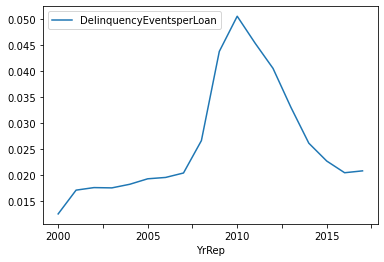

In [47]:
df_per_yr_summary=df_per_yr_summary.compute()
df_per_yr_summary['DelinquencyEventsperLoan']=df_per_yr_summary['DelinquentEvent']/df_per_yr_summary['LoanID']
df_per_yr_summary.to_pandas().sort_values(by=['YrRep']).plot.line(x='YrRep',y='DelinquencyEventsperLoan')

## Creating modeling dataset with label & features

Aggregate to one record per loan & flagging for delinquency event at least once historically

In [48]:
# This takes ~ 12-15 min with 2 A100 GPUs on 1.8B rows
df_per_loan = df_per.groupby('LoanID',as_index=False).agg({'DelinquentEvent':'sum'}).persist()
progress(df_per_loan)

VBox()

In [49]:
df_per_loan.head()

,LoanID,DelinquentEvent
0,185648046345,0
1,940160992979,0
2,338253480820,0
3,327180032737,0
4,287096047357,0


In [51]:
df_per_loan['DelinquentFlag']=0
df_per_loan['DelinquentFlag']=df_per_loan['DelinquentFlag'].where(df_per_loan['DelinquentEvent']<1,1)
df_per_loan[df_per_loan['DelinquentFlag']> 0].head()

,LoanID,DelinquentEvent,DelinquentFlag
6,736842854055,1,1
11,858243020041,15,1
24,229906838180,26,1
33,381137150529,1,1
35,769846953850,7,1


In [52]:
joined=df_acq.merge(df_per_loan,on=['LoanID'],how='left')
joined.head()

,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrLTV,OrCLTV,...,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,MortInsType,RelMortInd,DelinquentEvent,DelinquentFlag
0,183242426281,R,"JPMORGAN CHASE BANK, NA",8.375,137000.0,360.0,01/2000,03/2000,97.0,<NA>,...,P,OR,974,30.0,FRM,<NA>,1.0,N,0,0
1,183243108339,R,"WELLS FARGO BANK, N.A.",8.000,145000.0,360.0,11/1999,01/2000,80.0,<NA>,...,P,IL,604,<NA>,FRM,<NA>,<NA>,Y,1,1
2,183245218791,R,SUNTRUST MORTGAGE INC.,8.000,100000.0,180.0,01/2000,03/2000,33.0,<NA>,...,P,MD,210,<NA>,FRM,772.0,<NA>,N,0,0
3,183249720870,R,USAA FEDERAL SAVINGS BANK,8.000,212000.0,360.0,01/2000,03/2000,95.0,<NA>,...,P,PA,151,30.0,FRM,695.0,1.0,N,0,0
4,183251824837,R,OTHER,8.375,56000.0,360.0,02/2000,04/2000,48.0,<NA>,...,P,LA,700,<NA>,FRM,<NA>,<NA>,N,0,0


In [90]:
label=['DelinquentFlag']
cat_features=['Channel','OccStatus','FTHomeBuyer','LoanPurpose','PropertyType','ProductType','RelMortInd']
num_features=['OrInterestRate','OrUnpaidPrinc','OrLoanTerm','OrLTV','OrCLTV','CreditScore']
modeling_dataset=joined_categorized[cat_features + num_features + label]

In [91]:
modeling_dataset.dtypes

In [99]:
modeling_dataset=dask_df.get_dummies(modeling_dataset)

## Training a model

In [101]:
X = modeling_dataset[modeling_dataset.columns.difference(['DelinquentFlag'])]
y = modeling_dataset['DelinquentFlag']

In [102]:
dtrain=xgb.dask.DaskDeviceQuantileDMatrix(client, X,y)

In [104]:
param =  {
               'max_depth': 8,
               'objective': 'reg:squarederror',
               'tree_method': 'gpu_hist'
             }
model = xgb.dask.train(client,param, dtrain,num_boost_round=100)

In [110]:
## TODO --- Add in metrics, feature importance, & evaluation plots

## Appendix